In [ ]:
import pandas as pd

# Load the clean dataset with explicit encoding
df = pd.read_csv('clean_kaggle_data_2022.csv', encoding='ISO-8859-1')
df_head = pd.read_csv('clean_kaggle_data_2022.csv', encoding='ISO-8859-1', nrows=1)

# Get the first row as column names
column_names=df_head.columns.tolist()

# Drop the first two rows (header and unit information)
df = df[2:]

# Set the column names
df.columns = column_names

# Iterate through each column starting from the second column (index 1)
response_tally = []

for column in df.columns[1:]:
    responses = df[column].value_counts().reset_index()
    responses.columns = ['Response', 'Count']
    responses['Column'] = column
    response_tally.append(responses)

# Concatenate the response tally dataframes
result_df = pd.concat(response_tally, ignore_index=True)

# Save the result to an Excel file
result_df.to_excel('numberOfResponsesPerClass.xlsx', index=False)


In [66]:
import pandas as pd

# Load the Excel file into a DataFrame
df = pd.read_excel('response_tally.xlsx')

# Initialize an empty dictionary to hold string tallies
column_tally = {}

# Loop through each row in the "Column" column
for item in df['Column']:
    if item in column_tally:
        column_tally[item] += 1                        
    else:
        column_tally[item] = 1

# Convert the column tally dictionary to a DataFrame
output_df = pd.DataFrame(list(column_tally.items()), columns=['Column', 'Tally'])

# Save the DataFrame to a new Excel file
output_df.to_excel('numberOfclassesPerQuestion.xlsx', index=False)


In [27]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from category_encoders import BinaryEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2 #For feature selection
from sklearn.linear_model import LogisticRegression


In [17]:


# Load the dataset
df = pd.read_csv('clean_kaggle_data_2022.csv')

# Handling missing values by filling 'null' with 'unknown'

df = df.drop(['Q5'], axis=1) 
df = df.drop(['Duration (in seconds)','Q29'], axis=1)
df=df.drop(0)


#Set encoding labels manually for ordinal columns
Q2_encode = {'18-21':0, '22-24':1, '25-29':2, '30-34':3, '35-39':4, '40-44':5, '45-49':6, '50-54':7, '55-59':8, '60-64':9, '65-69:':10, '70+':11}
Q11_encode = {'I have never written code':0, '<1 years':1, '1-3 years':2, '3-5 years':3, '5-10 years':4, '10-20 years':5, '20+ years':6}
Q16_encode = {'I do not use machine learning methods':0, 'Under 1 year':1, '1-2 years':2, '2-3 years':3, '3-4 years':4, '4-5 years':5, '5-10 years':6, '10-20 years':7}
Q25_encode = {'0-49 employees':0, '50-249 employees':1, '250-999 employees':2, '1000-9,999 employees':3, '10,000 or more employees':4}
Q26_encode = {'0':0, '2-Jan':1, '4-Mar':2, '9-May':3, '14-Oct':4, '15-19':5, '20+':6}
Q30_encode = {'$0 ($USD)':0, '$1-$99':1, '$100-$999':2, '$1000-$9,999':3, '$0 ($USD)':4, '$10,000-$99,999':5, '$100,000 or more ($USD)':6}
Q43_encode = {'Never':0, 'Once':1, '2-5 times':2, '6-25 times':3, 'More than 25 times':4}

#Encode ordinal columns of dataset
df['Q2'] = df['Q2'].map(Q2_encode)
df['Q11'] = df['Q11'].map(Q11_encode)
df['Q16'] = df['Q16'].map(Q16_encode)
df['Q25'] = df['Q25'].map(Q25_encode)
df['Q26'] = df['Q26'].map(Q26_encode)
df['Q30'] = df['Q30'].map(Q30_encode)
df['Q43'] = df['Q43'].map(Q43_encode)

#Fill in missing data in ordinal columns with its mean
col_ordinal = ['Q2', 'Q11', 'Q16', 'Q25', 'Q26', 'Q30', 'Q43']
for col in col_ordinal:
    df[col].fillna(df[col].mean(), inplace=True)

#Encode Q9 column from Y/N to 0 and 1 and fill null with mean
df['Q9'] = df['Q9'].replace({'No': 0, 'Yes': 1})
df['Q9'].fillna(df['Q9'].mean(), inplace=True)

#Temporarily remove ordinal and target columns
removed_col = df[['Q2', 'Q11', 'Q16', 'Q25', 'Q26', 'Q30', 'Q43', 'Q9', 'Q29_Encoded', 'Q29_buckets']]
df = df.drop(columns=['Q2', 'Q11', 'Q16', 'Q25', 'Q26', 'Q30', 'Q43', 'Q9', 'Q29_Encoded', 'Q29_buckets'])

#Do one-hot encoding on rest of dataframe
df_encoded = pd.get_dummies(df)

#Reintroduce removed columns back into the dataframe
df_encoded = pd.concat([df_encoded,removed_col], axis=1)
df_encoded.head()


C:\Users\souren\AppData\Local\Temp\ipykernel_22844\2849909595.py:12: DtypeWarning: Columns (0,15,43,57,73,88,104,118,126,132,170,200,215,248,272,281,294) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('clean_kaggle_data_2022.csv')


,Q3_Man,Q3_Nonbinary,Q3_Prefer not to say,Q3_Prefer to self-describe,Q3_Woman,Q4_Algeria,Q4_Argentina,Q4_Australia,Q4_Bangladesh,Q4_Belgium,...,Q2,Q11,Q16,Q25,Q26,Q30,Q43,Q9,Q29_Encoded,Q29_buckets
1,True,False,False,False,False,False,False,False,False,False,...,8.0,5.0,2.0,0,1,3.0,2.000000,0.514341,2.0,"20,000-29,999"
2,True,False,False,False,False,False,False,False,False,False,...,3.0,5.0,5.0,2,6,4.0,0.924315,0.514341,10.0,"100,000-124,999"
3,True,False,False,False,False,False,False,True,False,False,...,11.0,6.0,6.0,3,6,2.0,0.000000,1.000000,10.0,"100,000-124,999"
4,True,False,False,False,False,False,False,False,False,False,...,5.0,5.0,6.0,3,6,2.0,2.000000,1.000000,13.0,"200,000-299,999"
5,True,False,False,False,False,False,False,False,False,False,...,5.0,5.0,6.0,3,2,6.0,4.000000,1.000000,13.0,"200,000-299,999"


In [20]:
#Create X (features) and y (target variables) dataframes for feature selection
X = df_encoded.drop(columns=['Q29_Encoded', 'Q29_buckets'],axis=1)
y = df_encoded['Q29_Encoded']

#Calculate chi squared scores of all features
chi_scores = chi2(X,y)
chi_scores

(array([1.49669016e+01, 2.70703066e+01, 1.57342290e+01, 1.57491420e+01,
        8.25941343e+01, 9.95229685e+00, 3.70017668e+01, 1.48950021e+02,
        3.19155302e+01, 4.35966972e+01, 7.03862752e+01, 1.60619933e+01,
        1.28421226e+02, 5.22109577e+01, 1.31366277e+01, 2.59818273e+01,
        4.43590603e+01, 7.28008953e+00, 7.20369804e+01, 4.23624472e+01,
        1.44103444e+02, 1.43824952e+02, 2.64912150e+01, 2.20304817e+01,
        1.35670431e+01, 8.07884505e+02, 8.07825144e+01, 3.10338874e+01,
        4.13731616e+01, 9.47807727e+01, 1.55340007e+02, 1.24802804e+02,
        2.34276291e+01, 1.71896427e+01, 3.74296188e+01, 2.00971423e+01,
        1.14813226e+01, 1.24133723e+02, 1.51248596e+02, 4.14184603e+01,
        1.18629080e+02, 2.63003872e+01, 2.25390959e+01, 6.19666097e+01,
        5.85870674e+01, 3.67076698e+01, 3.00177209e+01, 2.11295765e+01,
        3.67940678e+01, 1.57846132e+01, 6.13641278e+01, 1.60220455e+02,
        1.95543351e+01, 7.44327265e+01, 3.17456708e+01, 1.834456

In [22]:
print(len(chi_scores[0]))

396


<Axes: title={'center': 'Top 20 Highest Chi-squared Features'}, ylabel='Chi-squared'>

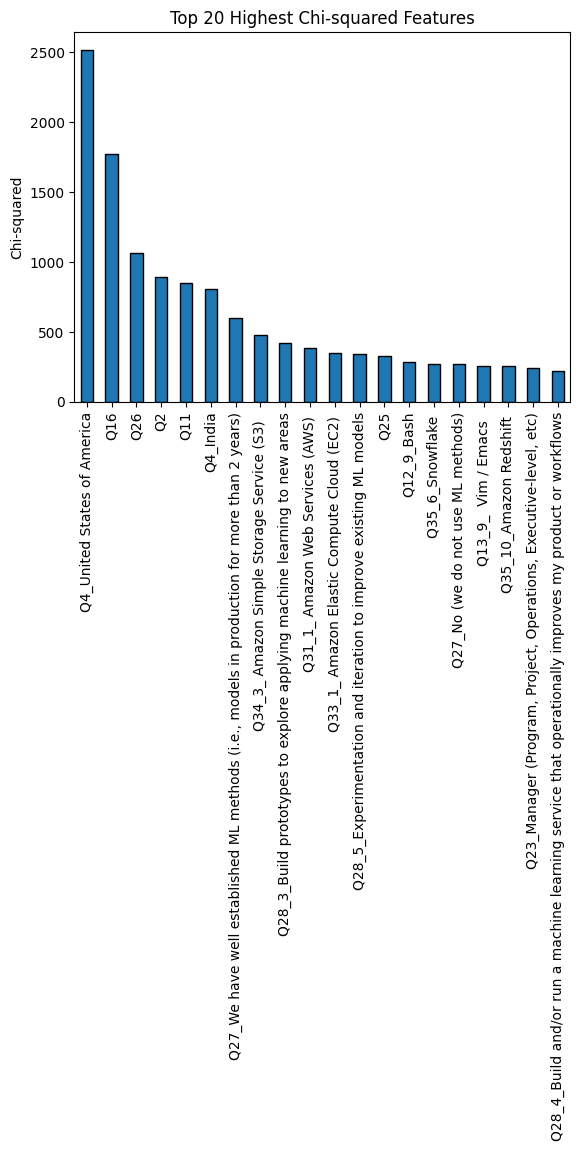

In [24]:
#Set number of features to be selected through chi squared
k = 396

#Plot chi squared of all encoded features, sorted from most important
chi_values = pd.Series(chi_scores[0], index=X.columns)
chi_values.sort_values(ascending=False, inplace=True)
plt.title("Top 20 Highest Chi-squared Features")
plt.ylabel("Chi-squared")
chi_values.head(20).plot.bar(edgecolor='black')

In [25]:
#Set features to be selected through K best
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)
selected_feature_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_feature_indices]
selected_features #shows selected features in alphabetical order
#Filter encoded dataframe to only have selected features
df_selected = df_encoded[selected_features]
df_selected = pd.concat([df_encoded[selected_features],df_encoded[['Q29_Encoded','Q29_buckets']]], axis=1)
df_selected.head()

,Q3_Man,Q3_Nonbinary,Q3_Prefer not to say,Q3_Prefer to self-describe,Q3_Woman,Q4_Algeria,Q4_Argentina,Q4_Australia,Q4_Bangladesh,Q4_Belgium,...,Q2,Q11,Q16,Q25,Q26,Q30,Q43,Q9,Q29_Encoded,Q29_buckets
1,True,False,False,False,False,False,False,False,False,False,...,8.0,5.0,2.0,0,1,3.0,2.000000,0.514341,2.0,"20,000-29,999"
2,True,False,False,False,False,False,False,False,False,False,...,3.0,5.0,5.0,2,6,4.0,0.924315,0.514341,10.0,"100,000-124,999"
3,True,False,False,False,False,False,False,True,False,False,...,11.0,6.0,6.0,3,6,2.0,0.000000,1.000000,10.0,"100,000-124,999"
4,True,False,False,False,False,False,False,False,False,False,...,5.0,5.0,6.0,3,6,2.0,2.000000,1.000000,13.0,"200,000-299,999"
5,True,False,False,False,False,False,False,False,False,False,...,5.0,5.0,6.0,3,2,6.0,4.000000,1.000000,13.0,"200,000-299,999"


In [26]:
#Create X and y dataframes for splitting and training
X = df_selected.drop(columns=['Q29_Encoded', 'Q29_buckets'],axis=1)
y = df_selected['Q29_Encoded']

#Split X and y with an 80:20 training-to-testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6508, 396)
X_test shape: (1628, 396)
y_train shape: (6508,)
y_test shape: (1628,)


In [ ]:
C = [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500]
score = []

for C_val in C:
    model = LogisticRegression(C=C_val,solver='lbfgs', multi_class='ovr',max_iter=10000)
    model.fit(X_train, y_train)
    score_val = model.score(X_train, y_train) #R2 score
    score.append(score_val)

plt.figure(figsize=(10, 5))
plt.semilogx(C, score, marker='o')
plt.title("C vs. R2 Score for Logistic Regression")
plt.xlabel("C (Regularization Strength)")
plt.ylabel("R2 Score")
plt.grid(True)
plt.show()

In [35]:
import torch
import torch.nn as nn
from torch.optim import SGD
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# Assuming X_train and y_train are your data and target values from before
# Ensure the data is scaled as PyTorch models can be sensitive to unscaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Define the logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, n_features):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(n_features, torch.max(y_train_tensor).item() + 1)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

# Initialize the model
model = LogisticRegressionModel(X_train_tensor.shape[1])

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01)

# Train the model
n_epochs = 100
for epoch in range(n_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()  # it sets the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = X_train_tensor.size(0)
    outputs = model(X_train_tensor.to(device))
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_train_tensor.to(device)).sum().item()

    print(f'Accuracy of the model on the training set is: {100 * correct / total} %')

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')


Epoch [1/100], Loss: 2.2906
Epoch [2/100], Loss: 1.7763
Epoch [3/100], Loss: 1.9788
Epoch [4/100], Loss: 2.1660
Epoch [5/100], Loss: 2.0811
Epoch [6/100], Loss: 1.7268
Epoch [7/100], Loss: 2.1654
Epoch [8/100], Loss: 1.9314
Epoch [9/100], Loss: 1.8586
Epoch [10/100], Loss: 1.7771
Epoch [11/100], Loss: 1.9381
Epoch [12/100], Loss: 1.7040
Epoch [13/100], Loss: 1.6260
Epoch [14/100], Loss: 1.6490
Epoch [15/100], Loss: 1.6366
Epoch [16/100], Loss: 1.6761
Epoch [17/100], Loss: 1.5346
Epoch [18/100], Loss: 1.6865
Epoch [19/100], Loss: 1.5711
Epoch [20/100], Loss: 1.4885
Epoch [21/100], Loss: 1.6206
Epoch [22/100], Loss: 1.5159
Epoch [23/100], Loss: 1.5366
Epoch [24/100], Loss: 1.4598
Epoch [25/100], Loss: 1.4144
Epoch [26/100], Loss: 1.5795
Epoch [27/100], Loss: 1.5288
Epoch [28/100], Loss: 1.4631
Epoch [29/100], Loss: 1.4965
Epoch [30/100], Loss: 1.9475
Epoch [31/100], Loss: 1.4744
Epoch [32/100], Loss: 1.4540
Epoch [33/100], Loss: 1.4162
Epoch [34/100], Loss: 1.6214
Epoch [35/100], Loss: 1